##Scrapping Google Apps Review - JakLingko
Week 2 NLP Pipeline PBA / Faiz Musyaffa Ramadhan / 5026221153

## Initial Setup

In [1]:
!pip install google_play_scraper
!pip install textblob
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 644.0 kB/s eta 0:00:00


In [2]:
from google_play_scraper import app
import pandas as pd
import numpy as np
import sklearn
import requests
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
import textblob
from pathlib import Path
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score
import pickle
import re
import time
import datetime
import os
from PIL import Image
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

%matplotlib inline
%config InlineBackend.figure_format='retina'

# Import seaborn styles explicitly
import seaborn as sns
# Apply the seaborn style before creating plots
sns.set_style("whitegrid")  # This line sets the Seaborn style
plt.rcParams["figure.figsize"] = (15,10)

## Get Raw Dataset

In [3]:
#Android App Jak Lingko from Google Play at https://play.google.com/store/apps/details?id=com.jaklingkoindonesia.app&hl=id
#The apps name on Google Play titled: Jaklingko by PT. Jakarta Lingko Indonesia
#Dated 4 September 2025 and N of reviews 2,62k

from google_play_scraper import app, Sort, reviews_all

jlingko_reviews = reviews_all(
    'com.jaklingkoindonesia.app',
    sleep_milliseconds=0, # defaults to 0
    lang='id', # defaults to 'en'
    sort=Sort.NEWEST, # defaults to Sort.MOST_RELEVANT
)

In [4]:
#Save JakLingko reviews into dataframe
df_jlingko = pd.DataFrame(np.array(jlingko_reviews),columns=['content'])
df_jlingko = df_jlingko.join(pd.DataFrame(df_jlingko.pop('content').tolist()))
df_jlingko.to_csv(r'df_jaklingko_raw', index=False)

## Exploratory Data Analysis (EDA)



In [5]:
# Check dataframe
df_jlingko

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,1f22f826-2b67-474c-84df-f2836ac24664,Astri Khairiah,https://play-lh.googleusercontent.com/a/ACg8oc...,udah 2x beli tiket ga muncul ga bisa di refund...,1,0,None,2025-09-10 14:26:39,Halo kak Astri Khairiah terima kasih telah men...,2025-09-10 14:22:52,None
1,59cae76d-a36a-4736-a665-b5f5b6229502,RMX OFFICIAL,https://play-lh.googleusercontent.com/a/ACg8oc...,oi jaklingko kenapa ni asu malah aplikasi tike...,1,0,1.6.14,2025-09-08 01:09:05,Halo kak RMX OFFICIAL terima kasih telah mengg...,2025-09-10 14:21:49,1.6.14
2,c16f69fc-1f11-40b9-8d44-f82c8f8bbec0,Syafaaterzs,https://play-lh.googleusercontent.com/a-/ALV-U...,"Aplikasi Gila, Server Bermasalah Terus Najis. ...",1,0,1.6.14,2025-09-08 01:05:10,Halo kak Syafaaterzs terima kasih telah menggu...,2025-09-10 14:20:21,1.6.14
3,59833db5-0207-4b12-8574-7095d514465c,PUTUT SUGIHARTO,https://play-lh.googleusercontent.com/a-/ALV-U...,APK SAMPAH. katanya pengembalian dana 7 hari k...,1,0,None,2025-09-05 02:41:04,Halo kak PUTUT SUGIHARTO terima kasih telah me...,2025-09-05 13:49:51,None
4,c8666e99-ba2f-4575-b9cd-9be401c1536a,Jidan Cut Achmad,https://play-lh.googleusercontent.com/a-/ALV-U...,idiot,1,0,1.6.14,2025-09-04 00:17:36,Halo kak Jidan Cut Achmad terima kasih telah m...,2025-09-04 14:58:05,1.6.14
...,...,...,...,...,...,...,...,...,...,...,...
1146,b6958e11-3013-475b-aa14-40a2251df018,Ahmad Fahrezi,https://play-lh.googleusercontent.com/a-/ALV-U...,Mantapp,5,1,1.0.10,2022-01-03 06:28:40,None,NaT,1.0.10
1147,7b5085b9-8f52-44af-9960-48dbbad838f6,chiva olivia bilah,https://play-lh.googleusercontent.com/a-/ALV-U...,mantapp aplikasinya,5,0,1.0.10,2022-01-03 06:28:39,None,NaT,1.0.10
1148,8be9de9d-fc82-419b-b1a3-8143505f80dc,Debby Bella dhina,https://play-lh.googleusercontent.com/a/ACg8oc...,Wow akhirnya bisa coba Jak Lingko App ini. Mak...,5,6,1.0.10,2022-01-03 05:10:16,Thank you Sist. Please do not hesitate if you ...,2022-01-03 06:12:35,1.0.10
1149,7182eb62-5d8b-48d0-87cc-b75f86771f3e,Anindia Putri herawan,https://play-lh.googleusercontent.com/a/ACg8oc...,Saya pengguna baru...baru download...sdh lihat...,3,7,1.0.10,2022-01-02 03:29:23,Hi Sista. Thanks for the stars. Because JakLin...,2022-01-03 06:08:19,1.0.10


In [6]:
df_jlingko.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1151 entries, 0 to 1150
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              1151 non-null   object        
 1   userName              1151 non-null   object        
 2   userImage             1151 non-null   object        
 3   content               1151 non-null   object        
 4   score                 1151 non-null   int64         
 5   thumbsUpCount         1151 non-null   int64         
 6   reviewCreatedVersion  937 non-null    object        
 7   at                    1151 non-null   datetime64[ns]
 8   replyContent          828 non-null    object        
 9   repliedAt             828 non-null    datetime64[ns]
 10  appVersion            937 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 99.0+ KB


In [7]:
#We do not need data for column reviewId, userName, userImage so we will show only these column
df_jlingko.loc[:,["content","score","thumbsUpCount", "reviewCreatedVersion", "at", "replyContent", "repliedAt"]]

,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,udah 2x beli tiket ga muncul ga bisa di refund...,1,0,None,2025-09-10 14:26:39,Halo kak Astri Khairiah terima kasih telah men...,2025-09-10 14:22:52
1,oi jaklingko kenapa ni asu malah aplikasi tike...,1,0,1.6.14,2025-09-08 01:09:05,Halo kak RMX OFFICIAL terima kasih telah mengg...,2025-09-10 14:21:49
2,"Aplikasi Gila, Server Bermasalah Terus Najis. ...",1,0,1.6.14,2025-09-08 01:05:10,Halo kak Syafaaterzs terima kasih telah menggu...,2025-09-10 14:20:21
3,APK SAMPAH. katanya pengembalian dana 7 hari k...,1,0,None,2025-09-05 02:41:04,Halo kak PUTUT SUGIHARTO terima kasih telah me...,2025-09-05 13:49:51
4,idiot,1,0,1.6.14,2025-09-04 00:17:36,Halo kak Jidan Cut Achmad terima kasih telah m...,2025-09-04 14:58:05
...,...,...,...,...,...,...,...
1146,Mantapp,5,1,1.0.10,2022-01-03 06:28:40,None,NaT
1147,mantapp aplikasinya,5,0,1.0.10,2022-01-03 06:28:39,None,NaT
1148,Wow akhirnya bisa coba Jak Lingko App ini. Mak...,5,6,1.0.10,2022-01-03 05:10:16,Thank you Sist. Please do not hesitate if you ...,2022-01-03 06:12:35
1149,Saya pengguna baru...baru download...sdh lihat...,3,7,1.0.10,2022-01-02 03:29:23,Hi Sista. Thanks for the stars. Because JakLin...,2022-01-03 06:08:19


In [8]:
#Check number of reviews scores
df_jlingko['score'].value_counts()

,count
score,
1,700
5,306
2,68
3,51
4,26


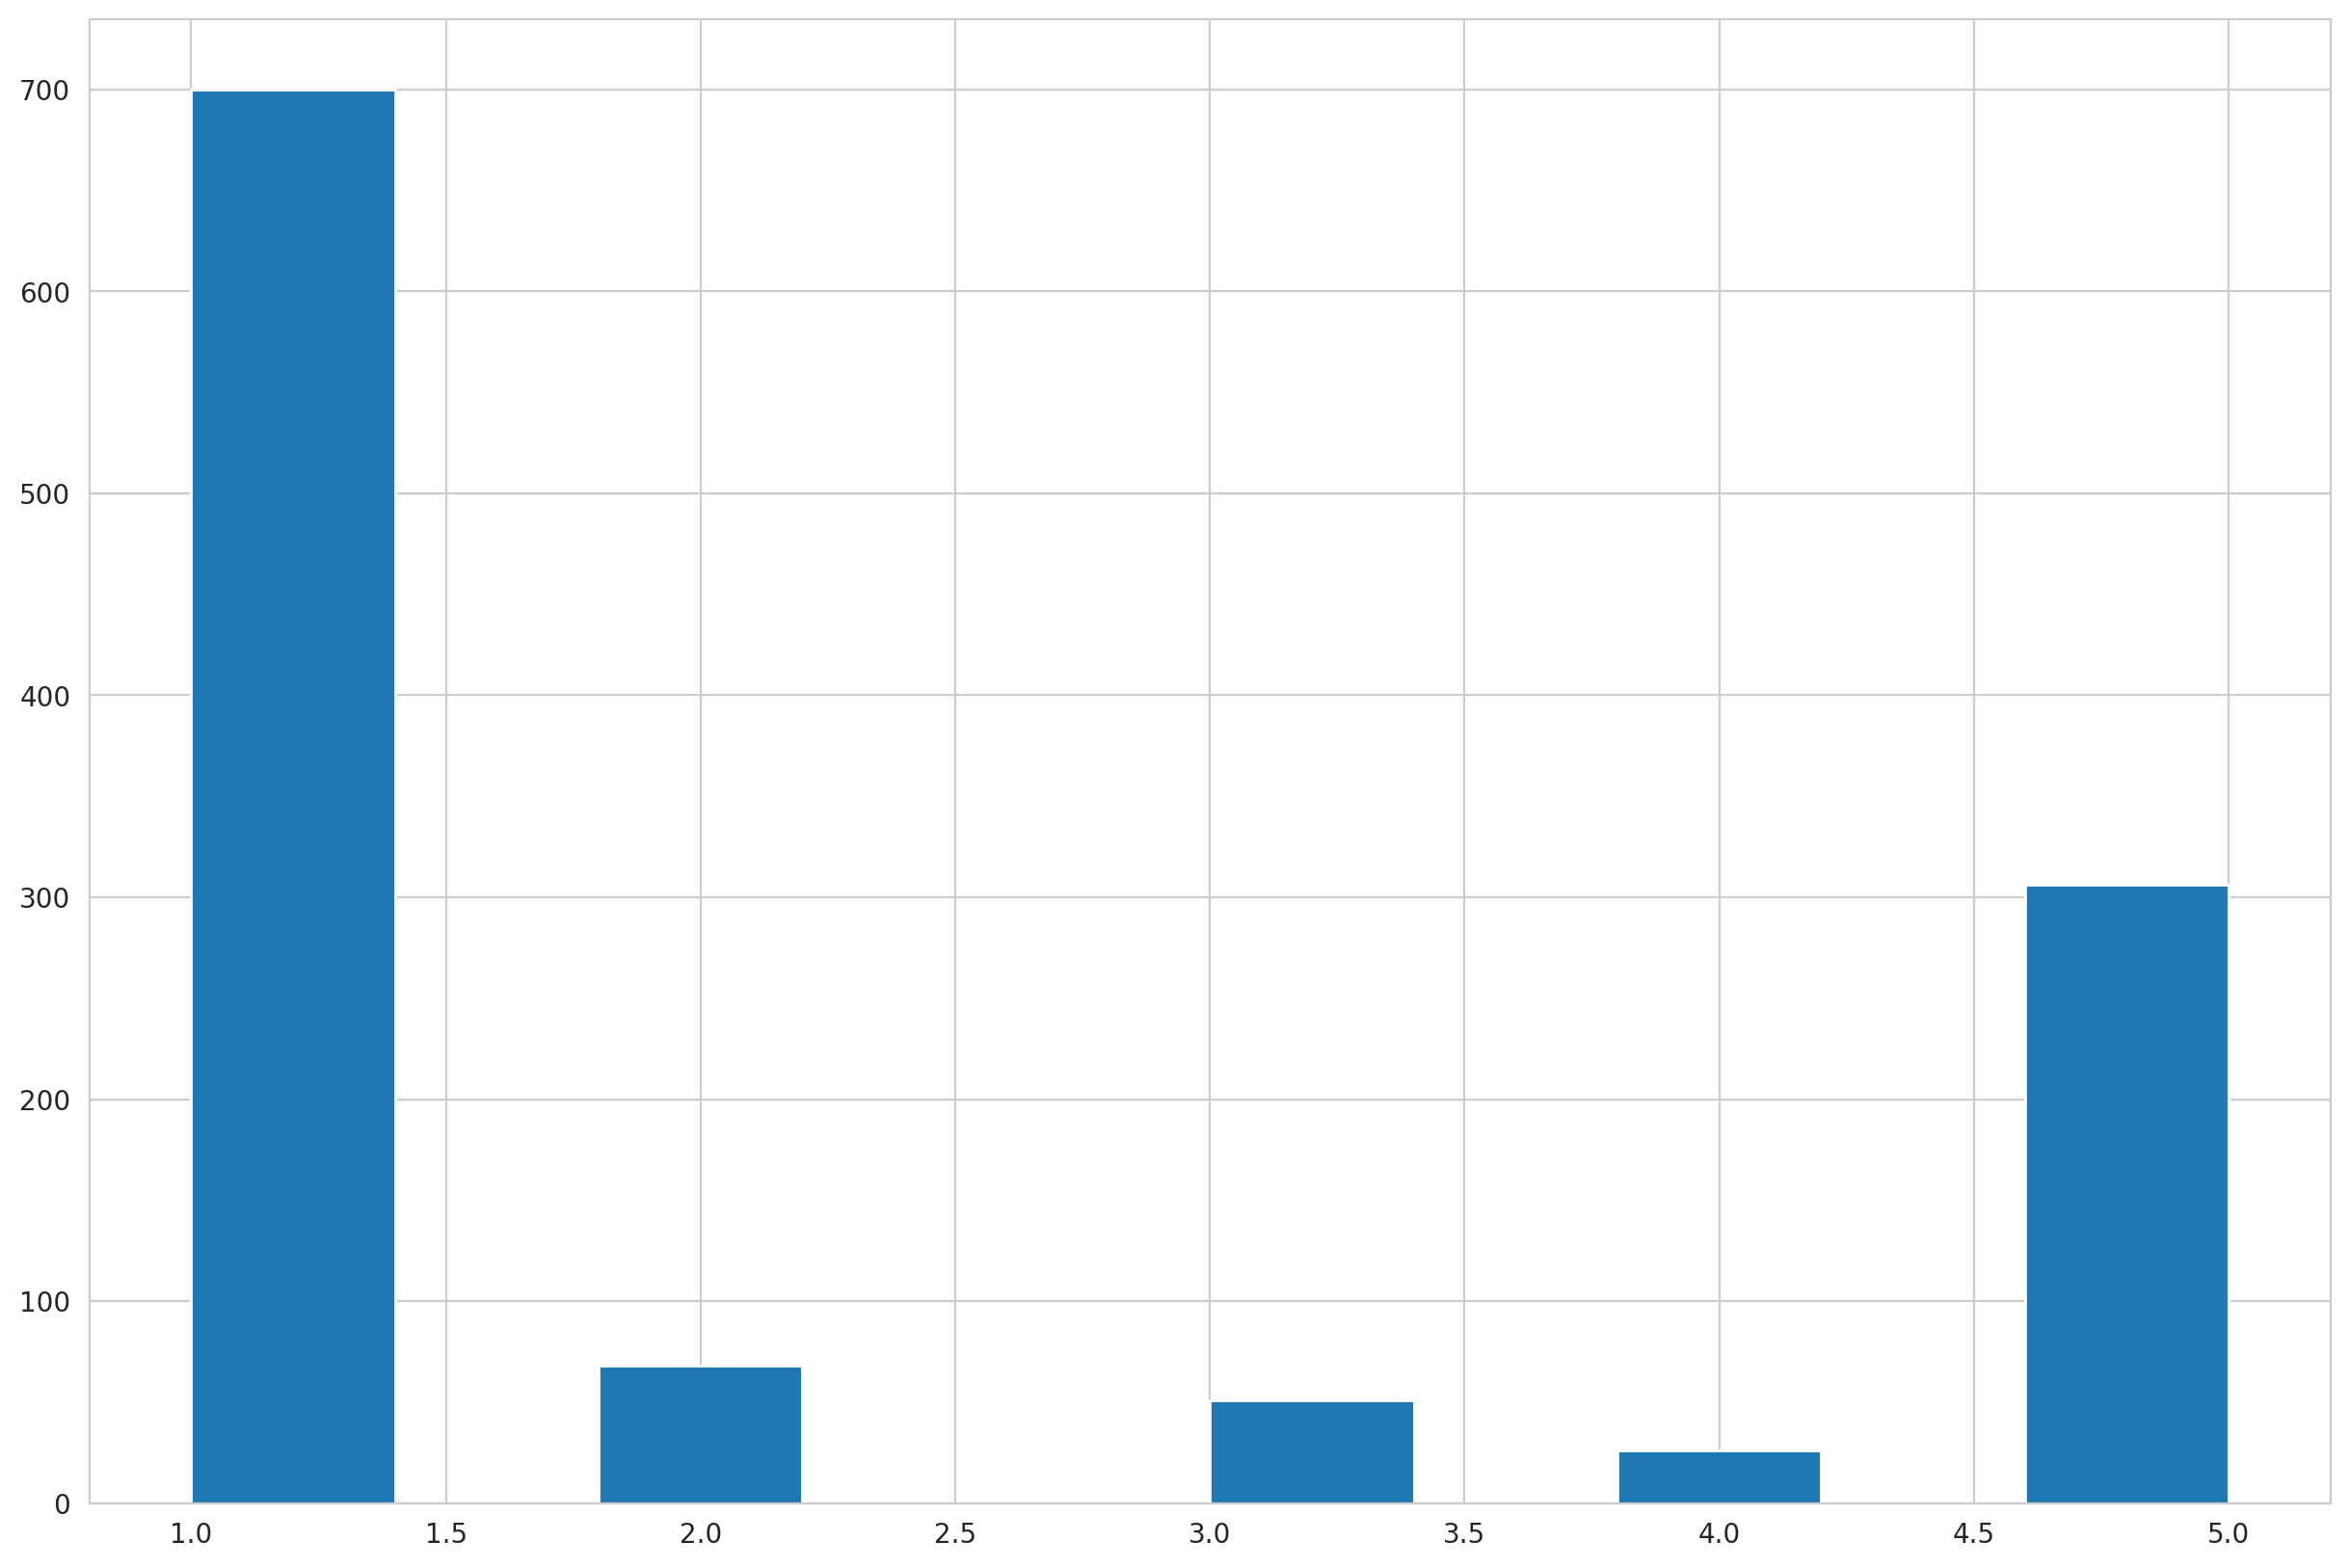

In [9]:
# Score distribution check
plt.hist(df_jlingko['score'])
plt.show()

## Text Preprocessing

### Lowercasing

In [10]:
# Lower casing
# Change the reviews type to string
df_jlingko['content'] = df_jlingko['content'].astype(str)# Before lowercasing
# Before lowercasing
print(df_jlingko['content'][188])
print(df_jlingko['content'][1])
print(df_jlingko['content'][1000])

apk setiap hari eror ga bisa di gunain gada bantu² nya pisan jangan down apk ini ,nyesel
oi jaklingko kenapa ni asu malah aplikasi tiket bermasalah kita mau keluar gk bisa asu di korupsi mulu , ini kenapa aplikasi bermasalah gw udah bayar woi.
Bagus.aplikasi jaklingko.


In [11]:
#Lowercase all reviews to see the difference
df_jlingko['content']= df_jlingko['content'].apply(lambda x: x.lower())
print(df_jlingko['content'][188])
print(df_jlingko['content'][1])
print(df_jlingko['content'][1000])

apk setiap hari eror ga bisa di gunain gada bantu² nya pisan jangan down apk ini ,nyesel
oi jaklingko kenapa ni asu malah aplikasi tiket bermasalah kita mau keluar gk bisa asu di korupsi mulu , ini kenapa aplikasi bermasalah gw udah bayar woi.
bagus.aplikasi jaklingko.


### Tokenization

In [12]:
import nltk
from nltk.tokenize import word_tokenize

# pastikan resource punkt udah ada
nltk.download('punkt_tab')

# bikin kolom baru 'tokens' hasil tokenisasi
df_jlingko['tokens'] = df_jlingko['content'].apply(word_tokenize)

# cek hasilnya
print(df_jlingko[['content', 'tokens']].head(10))


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


                                             content  \
0  udah 2x beli tiket ga muncul ga bisa di refund...   
1  oi jaklingko kenapa ni asu malah aplikasi tike...   
2  aplikasi gila, server bermasalah terus najis. ...   
3  apk sampah. katanya pengembalian dana 7 hari k...   
4                                              idiot   
5            kode otp nya ko tidak dikasih trus ya..   
6          sumpah supir jaklingko ga ada yang ramahh   
7  beli tiket mrt. dana kepotong, tiket barcode t...   
8  jk 41 jangan pada malas napa kerja woi setenga...   
9  gak kartu, gak aplikasi sama sama perlu di upg...   

                                              tokens  
0  [udah, 2x, beli, tiket, ga, muncul, ga, bisa, ...  
1  [oi, jaklingko, kenapa, ni, asu, malah, aplika...  
2  [aplikasi, gila, ,, server, bermasalah, terus,...  
3  [apk, sampah, ., katanya, pengembalian, dana, ...  
4                                            [idiot]  
5  [kode, otp, nya, ko, tidak, dikasih, trus, ya,... 

### Before Stop Words Preprocessing

In [13]:
# function to plot most frequent terms
def freq_words(x, terms=30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    # Import FreqDist from nltk.probability
    from nltk.probability import FreqDist
    fdist = FreqDist(all_words)

    words_df = pd.DataFrame({
        'word': list(fdist.keys()),
        'count': list(fdist.values())
    })

    # selecting top N most frequent words
    d = words_df.nlargest(columns="count", n=terms)

    plt.figure(figsize=(20, 5))
    # Use the 'rainbow' colormap for the bar plot
    ax = sns.barplot(data=d, x="word", y="count", palette="rainbow")
    ax.set(ylabel='Count')

    # Tambahin title
    plt.title(f"Most Frequent Words (Before Stop Words Removal) - Top {terms}")

    plt.show()

/tmp/ipython-input-2314564518.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=d, x="word", y="count", palette="rainbow")


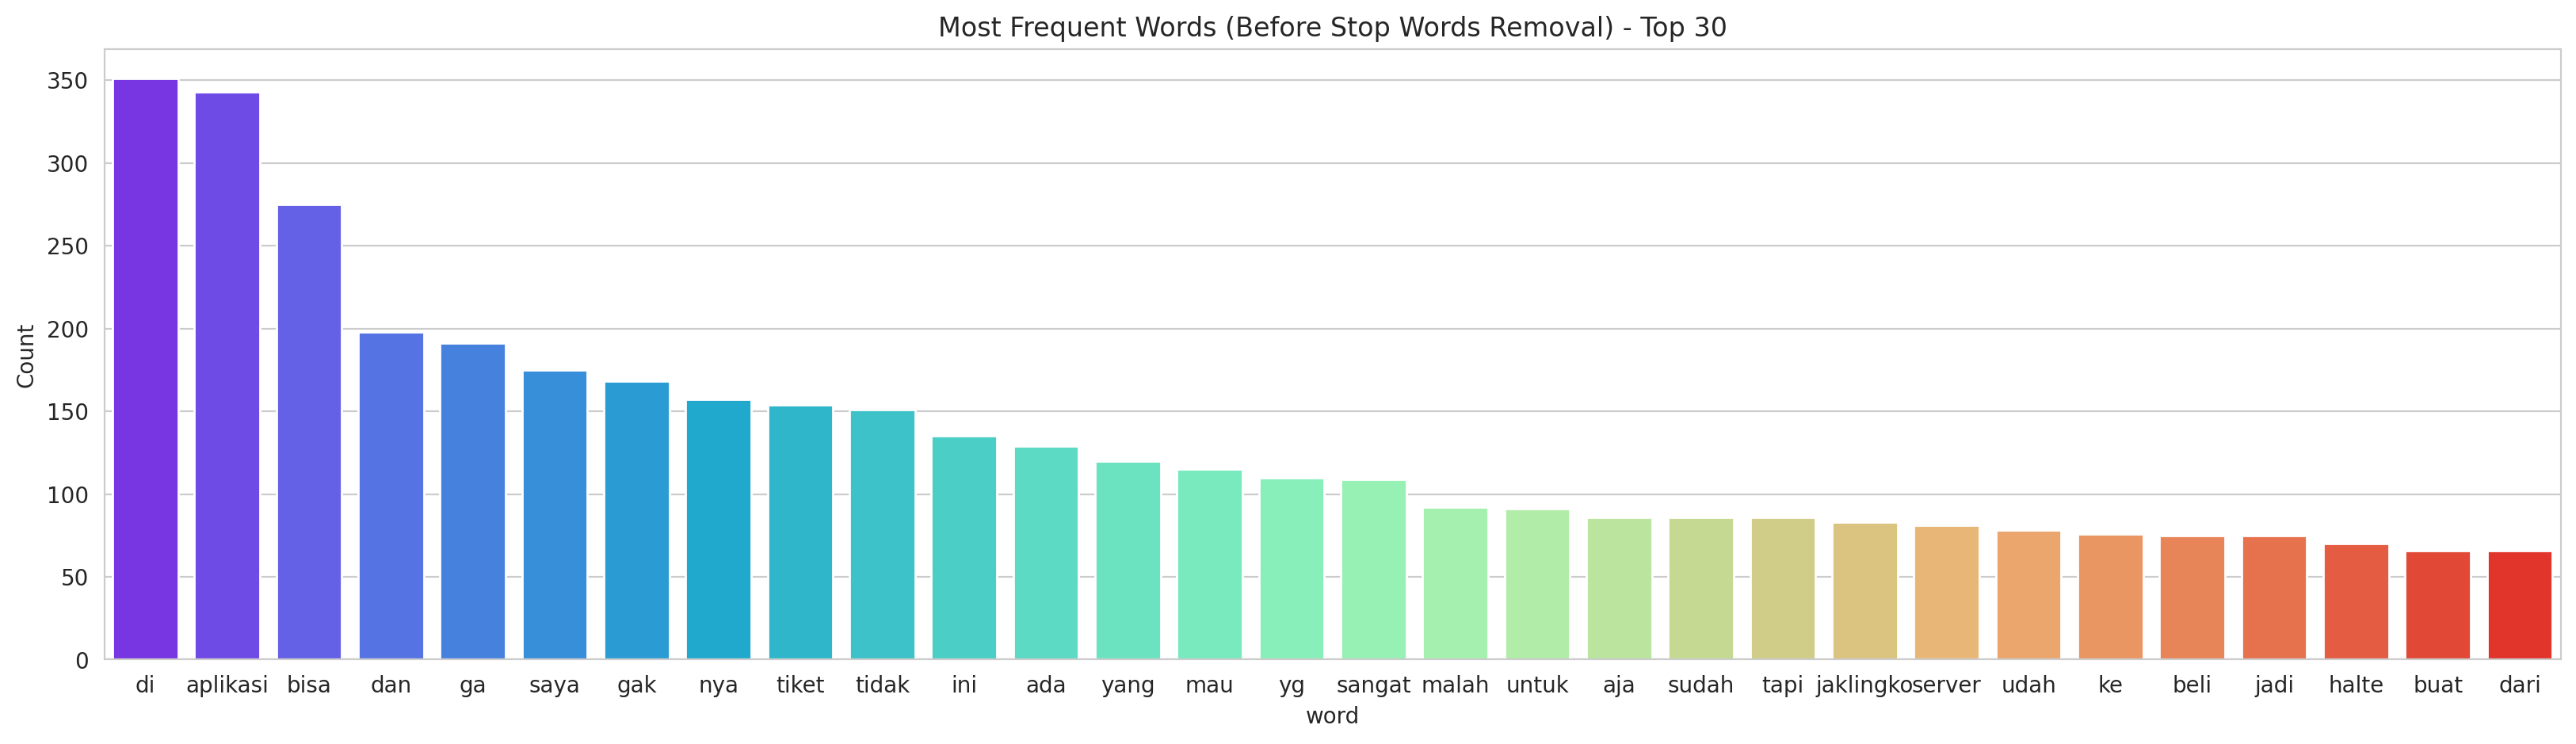

In [14]:
freq_words(df_jlingko['content'])

### Stopwords Removal (Indonesian Stopwords)

In [15]:
import nltk
import matplotlib.pyplot as plt
import pandas as pd
from nltk.corpus import stopwords
from collections import Counter

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [16]:
# Get Indonesian stopwords
indonesian_stopwords = stopwords.words('indonesian')

# Display first 20 stopwords
print(indonesian_stopwords[:20])

['ada', 'adalah', 'adanya', 'adapun', 'agak', 'agaknya', 'agar', 'akan', 'akankah', 'akhir', 'akhiri', 'akhirnya', 'aku', 'akulah', 'amat', 'amatlah', 'anda', 'andalah', 'antar', 'antara']


,Word,Frequency
0,aplikasi,343
1,ga,191
2,gak,168
3,nya,157
4,tiket,154
...,...,...
95,refund,17
96,kerja,17
97,sistem,17
98,sih,17


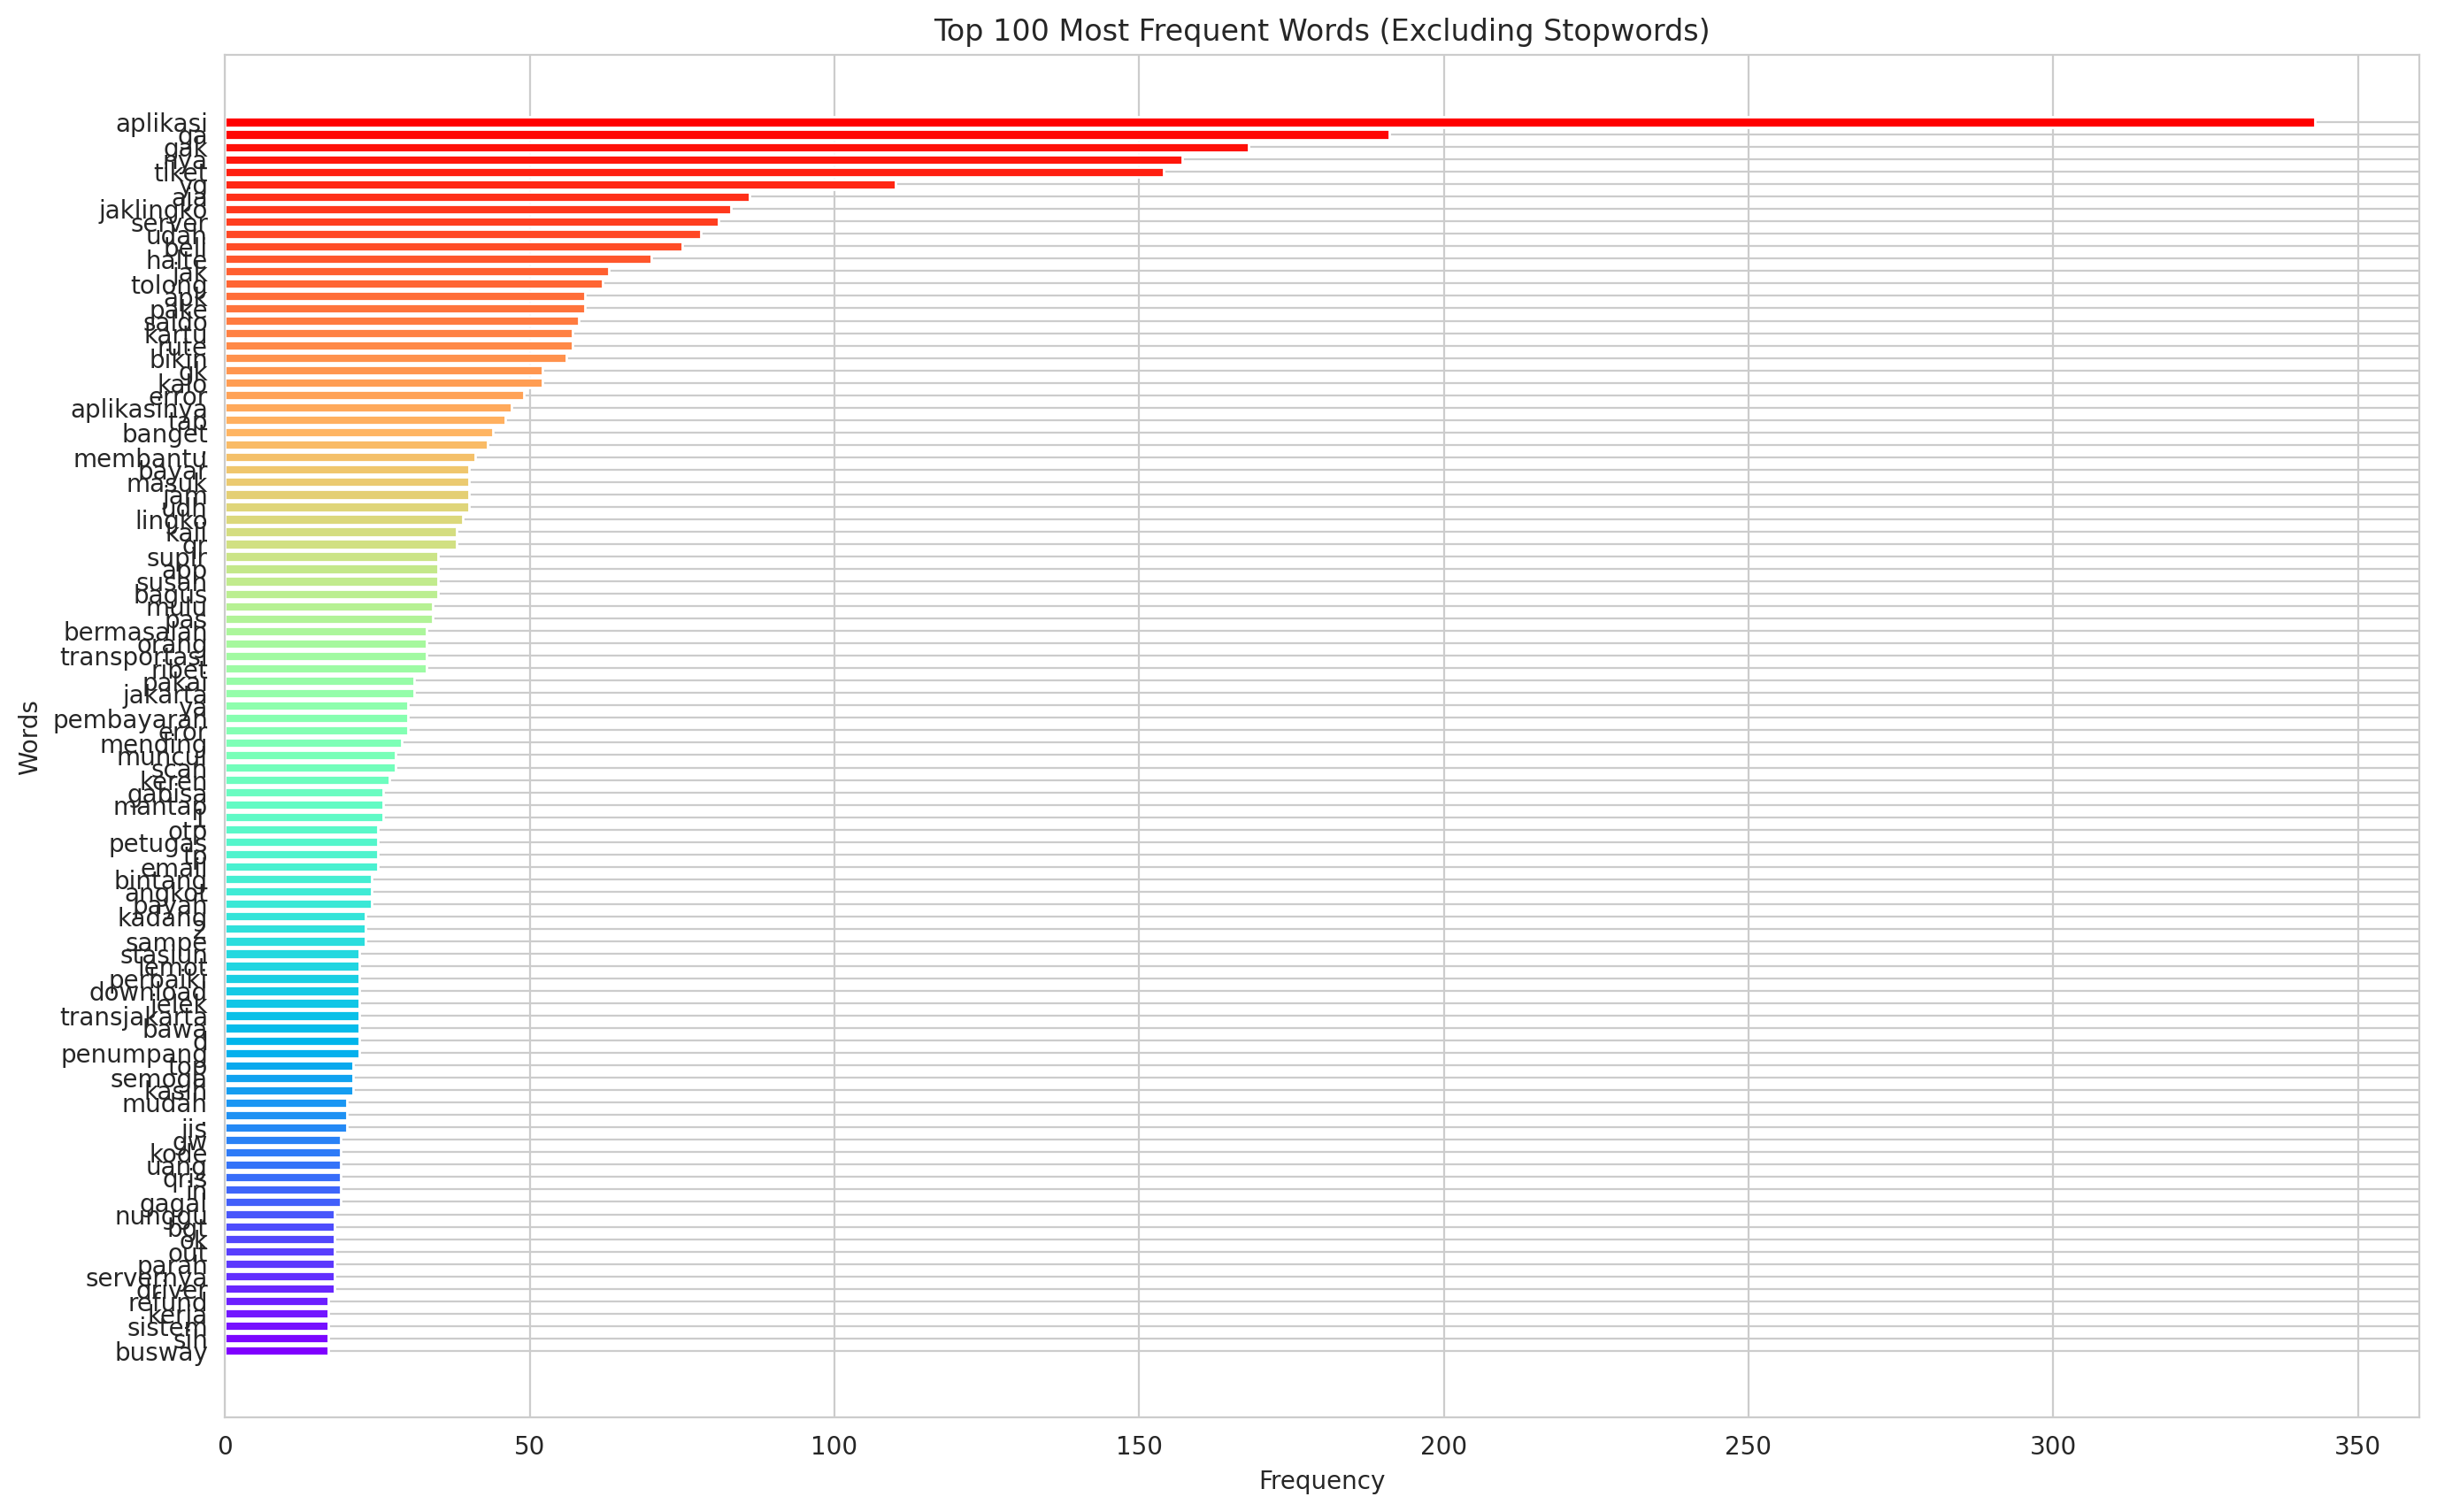

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter

# Assuming the text column is named 'content'
text_column = 'content'

# Combine all text data into one string
all_text = ' '.join(df_jlingko[text_column].dropna().astype(str))

# Tokenize words and remove stopwords
words = all_text.split()
filtered_words = [word.lower() for word in words if word.lower() not in indonesian_stopwords]

# Count frequent words
word_counts = Counter(filtered_words)
common_words = word_counts.most_common(100)

# Convert to DataFrame for better visualization
word_freq_df = pd.DataFrame(common_words, columns=['Word', 'Frequency'])

# Display the most common words
display(word_freq_df)

# Plot the frequent words with rainbow colormap (horizontal barplot)
plt.figure(figsize=(16, 10))

# generate warna rainbow sesuai jumlah kata
colors = plt.cm.rainbow(np.linspace(0, 1, len(word_freq_df)))

# plot horizontal bar
bars = plt.barh(
    word_freq_df['Word'][::-1],
    word_freq_df['Frequency'][::-1],
    color=colors
)

plt.xlabel("Frequency")
plt.ylabel("Words")
plt.title("Top 100 Most Frequent Words (Excluding Stopwords)")
plt.show()


In [18]:
common_words

[('aplikasi', 343),
 ('ga', 191),
 ('gak', 168),
 ('nya', 157),
 ('tiket', 154),
 ('yg', 110),
 ('aja', 86),
 ('jaklingko', 83),
 ('server', 81),
 ('udah', 78),
 ('beli', 75),
 ('halte', 70),
 ('jak', 63),
 ('tolong', 62),
 ('apk', 59),
 ('pake', 59),
 ('saldo', 58),
 ('kartu', 57),
 ('rute', 57),
 ('bikin', 56),
 ('gk', 52),
 ('kalo', 52),
 ('error', 49),
 ('aplikasinya', 47),
 ('tap', 46),
 ('banget', 44),
 (',', 43),
 ('membantu', 41),
 ('bayar', 40),
 ('masuk', 40),
 ('jam', 40),
 ('udh', 40),
 ('lingko', 39),
 ('kali', 38),
 ('qr', 38),
 ('supir', 35),
 ('app', 35),
 ('susah', 35),
 ('bagus', 35),
 ('mulu', 34),
 ('pas', 34),
 ('bermasalah', 33),
 ('orang', 33),
 ('transportasi', 33),
 ('ribet', 33),
 ('pakai', 31),
 ('jakarta', 31),
 ('ya', 30),
 ('pembayaran', 30),
 ('eror', 30),
 ('mending', 29),
 ('muncul', 28),
 ('scan', 28),
 ('keren', 27),
 ('gabisa', 26),
 ('mantap', 26),
 ('1', 26),
 ('otp', 25),
 ('petugas', 25),
 ('tp', 25),
 ('email', 25),
 ('bintang', 24),
 ('angkot',

In [19]:
# Pastikan indonesian_stopwords berbentuk set
indonesian_stopwords = set(indonesian_stopwords)

# Add custom stopwords dari hasil top 100 frequent words
custom_stopwords = {
    # filler umum
    "ga", "gak", "gk", "udah", "udh", "aja", "aja", "aja", "ya", "tp", "bgt", "ok", "gw", "sih",
    # kata ganti/partikel
    "nya", "yg", "kalo", "d", "in",
    # tanda baca/angka
    ",", ".", "1", "2",
    # umum tidak bermakna kontekstual
    "aja", "mulu", "udah", "udh", "sampe"
}


# Pastikan kata-kata penting tidak ikut jadi stopwords
for word in ["aplikasi", "apk", "app"]:
    indonesian_stopwords.discard(word)

# Merge with existing stopwords
indonesian_stopwords.update(custom_stopwords)

print("Updated stopwords:", sorted(indonesian_stopwords))


Updated stopwords: [',', '.', '1', '2', 'ada', 'adalah', 'adanya', 'adapun', 'agak', 'agaknya', 'agar', 'aja', 'akan', 'akankah', 'akhir', 'akhiri', 'akhirnya', 'aku', 'akulah', 'amat', 'amatlah', 'anda', 'andalah', 'antar', 'antara', 'antaranya', 'apa', 'apaan', 'apabila', 'apakah', 'apalagi', 'apatah', 'artinya', 'asal', 'asalkan', 'atas', 'atau', 'ataukah', 'ataupun', 'awal', 'awalnya', 'bagai', 'bagaikan', 'bagaimana', 'bagaimanakah', 'bagaimanapun', 'bagi', 'bagian', 'bahkan', 'bahwa', 'bahwasanya', 'baik', 'bakal', 'bakalan', 'balik', 'banyak', 'bapak', 'baru', 'bawah', 'beberapa', 'begini', 'beginian', 'beginikah', 'beginilah', 'begitu', 'begitukah', 'begitulah', 'begitupun', 'bekerja', 'belakang', 'belakangan', 'belum', 'belumlah', 'benar', 'benarkah', 'benarlah', 'berada', 'berakhir', 'berakhirlah', 'berakhirnya', 'berapa', 'berapakah', 'berapalah', 'berapapun', 'berarti', 'berawal', 'berbagai', 'berdatangan', 'beri', 'berikan', 'berikut', 'berikutnya', 'berjumlah', 'berkali-k

### Stopwords x Tokenization

🔎 Words removed by custom stopwords:


,Word,Frequency
0,di,351
1,bisa,275
2,dan,198
3,ga,191
4,saya,175
...,...,...
335,kepada,1
336,mirip,1
337,apabila,1
338,masing-masing,1


,Word,Frequency
0,aplikasi,343
1,tiket,154
2,jaklingko,83
3,server,81
4,beli,75
...,...,...
95,g,15
96,ngga,15
97,biar,15
98,user,15


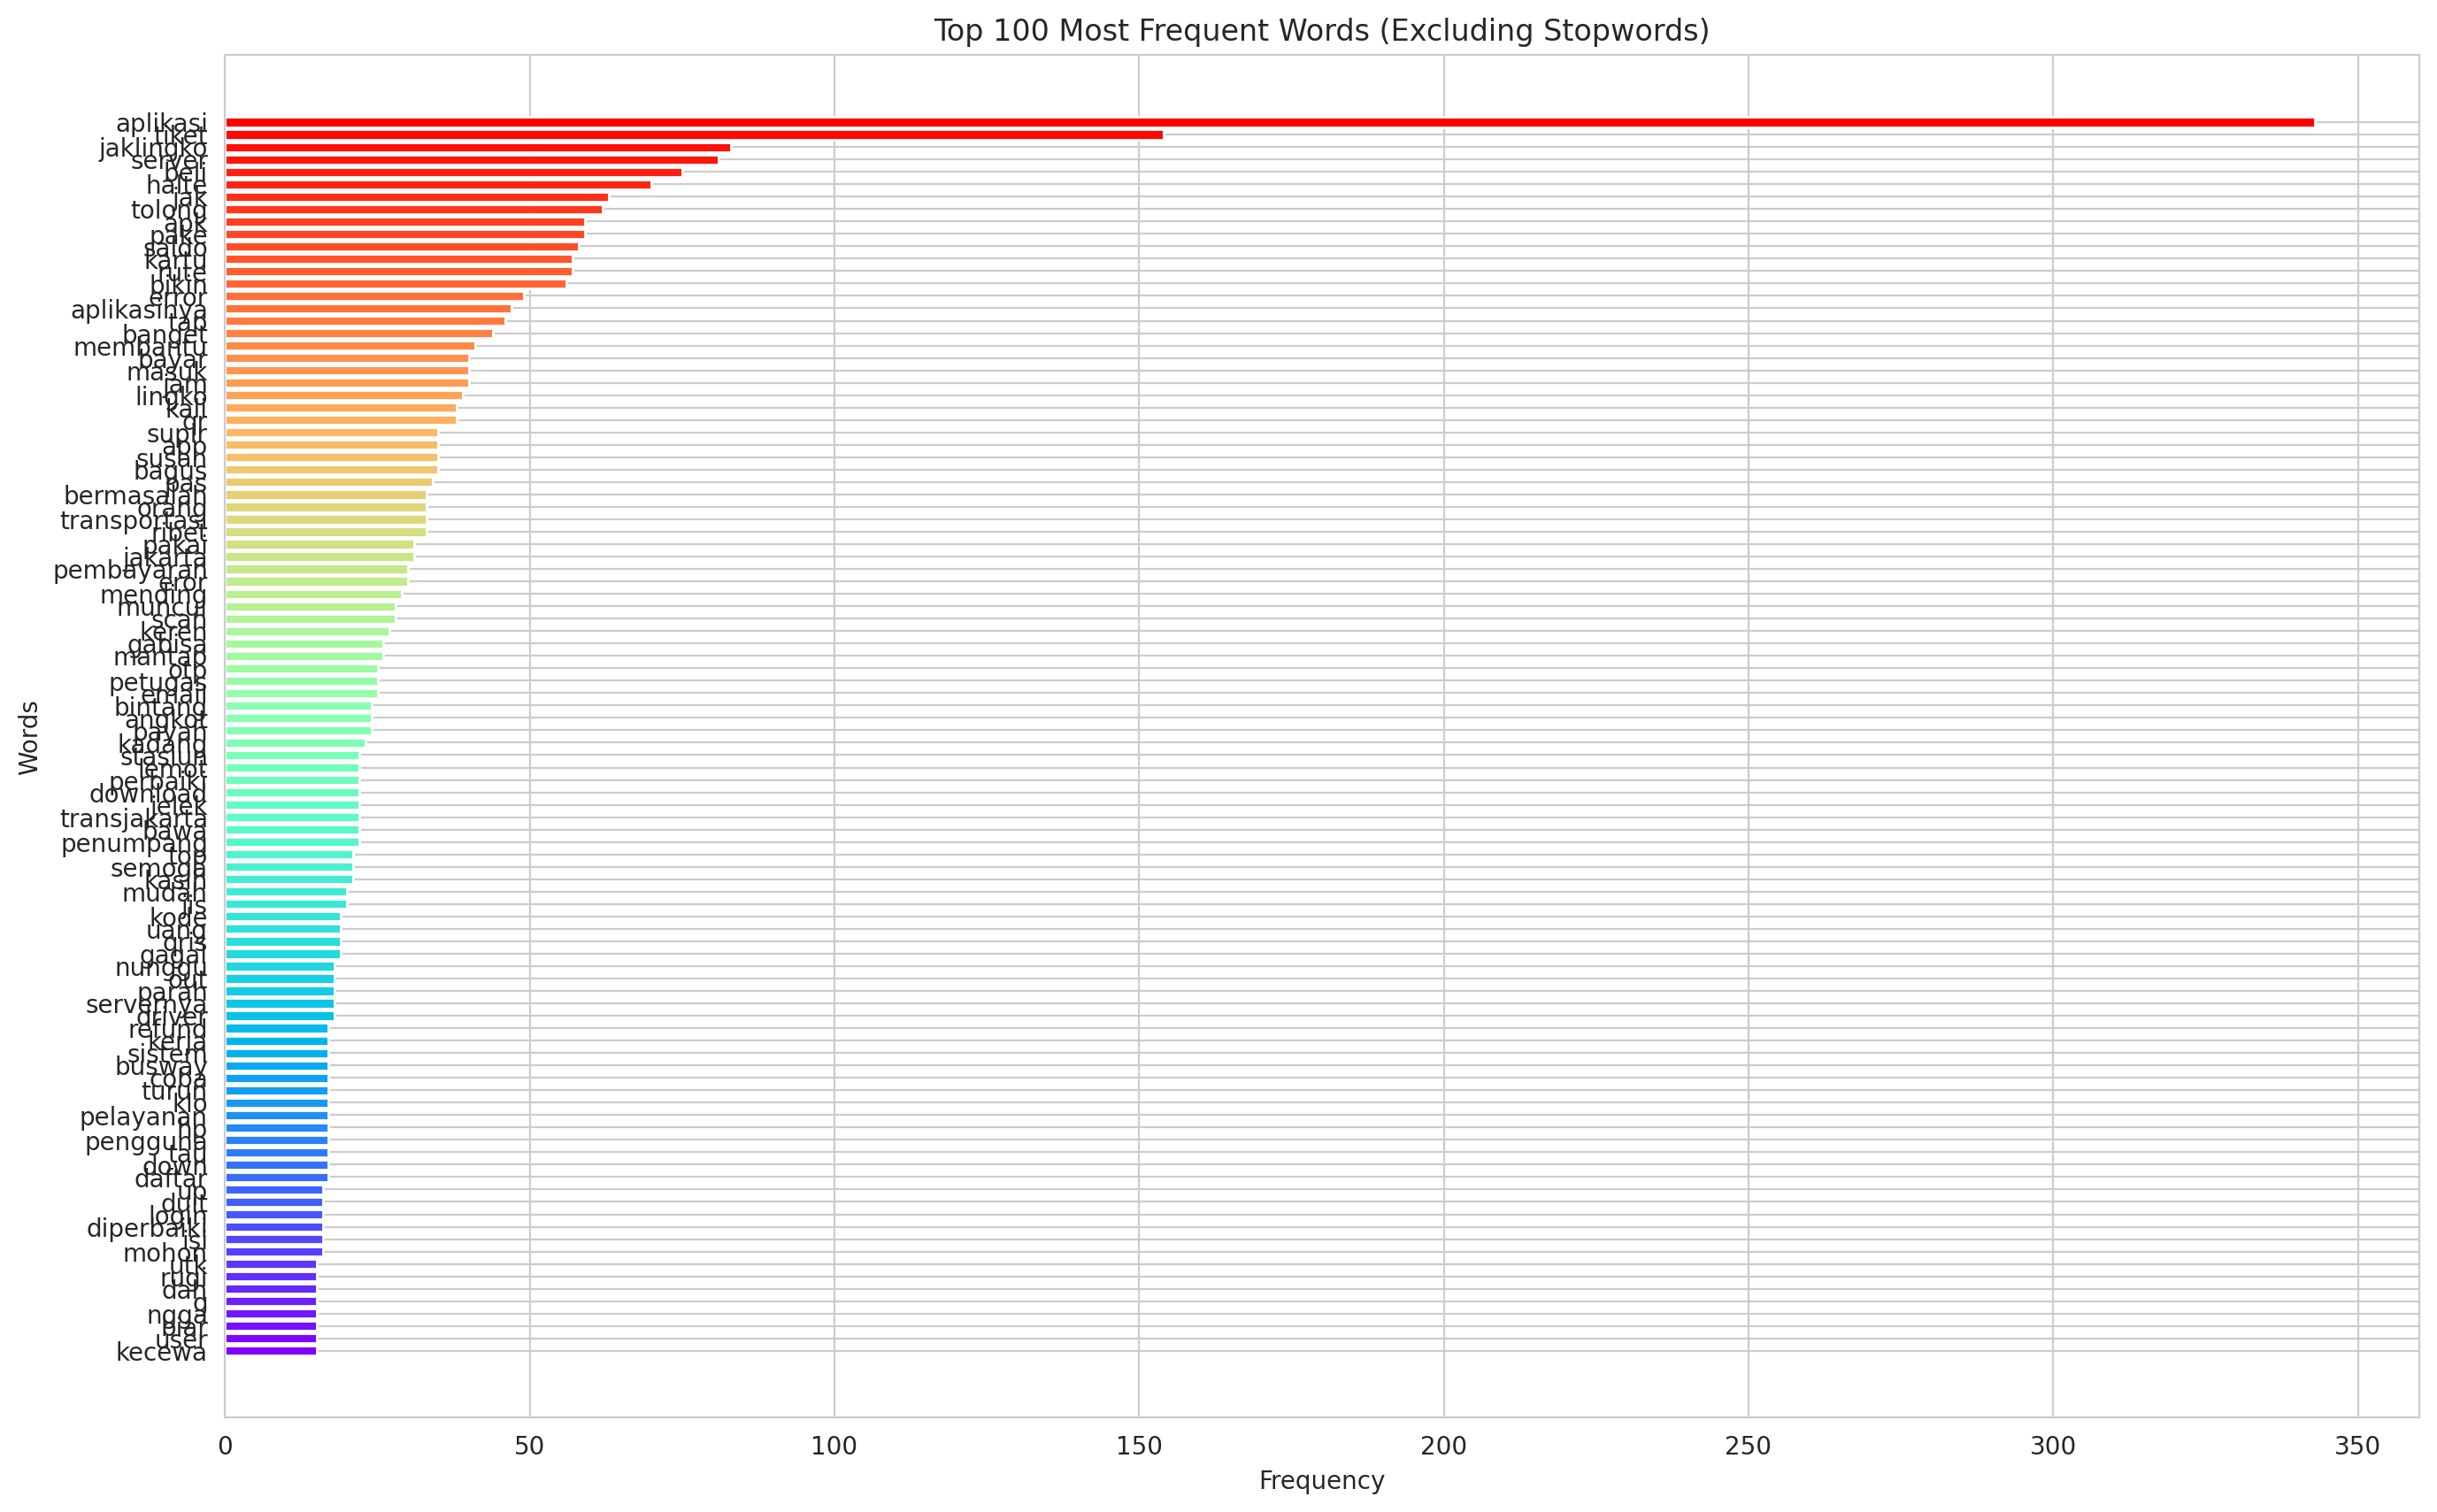

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter

# Assuming the text column is named 'content'
text_column = 'content'

# Combine all text data into one string
all_text = ' '.join(df_jlingko[text_column].dropna().astype(str))

# Tokenize words
words = [word.lower() for word in all_text.split()]

# Cari kata yang kehapus karena stopwords
removed_words = [word for word in words if word in indonesian_stopwords]

# Hitung frekuensi kata yang kehapus
removed_counts = Counter(removed_words)
removed_df = pd.DataFrame(removed_counts.most_common(), columns=['Word', 'Frequency'])

print("🔎 Words removed by custom stopwords:")
display(removed_df)

# Filter stopwords
filtered_words = [word for word in words if word not in indonesian_stopwords]

# Count frequent words
word_counts = Counter(filtered_words)
common_words = word_counts.most_common(100)

# Convert to DataFrame for better visualization
word_freq_df = pd.DataFrame(common_words, columns=['Word', 'Frequency'])

# Display the most common words
display(word_freq_df)

# Plot the frequent words with rainbow colormap (horizontal barplot)
plt.figure(figsize=(16, 10))

# generate warna rainbow sesuai jumlah kata
colors = plt.cm.rainbow(np.linspace(0, 1, len(word_freq_df)))

# plot horizontal bar
bars = plt.barh(
    word_freq_df['Word'][::-1],
    word_freq_df['Frequency'][::-1],
    color=colors
)

plt.xlabel("Frequency")
plt.ylabel("Words")
plt.title("Top 100 Most Frequent Words (Excluding Stopwords)")
plt.show()


In [21]:
# fungsi untuk hapus stopwords
def remove_stopwords(text):
    if isinstance(text, str):
        words = text.lower().split()
        return ' '.join([w for w in words if w not in indonesian_stopwords])
    return text

# bikin kolom baru di dataframe
df_jlingko['clean_content'] = df_jlingko['content'].apply(remove_stopwords)

# cek hasil
print(df_jlingko[['content', 'clean_content']].head(10))


                                             content  \
0  udah 2x beli tiket ga muncul ga bisa di refund...   
1  oi jaklingko kenapa ni asu malah aplikasi tike...   
2  aplikasi gila, server bermasalah terus najis. ...   
3  apk sampah. katanya pengembalian dana 7 hari k...   
4                                              idiot   
5            kode otp nya ko tidak dikasih trus ya..   
6          sumpah supir jaklingko ga ada yang ramahh   
7  beli tiket mrt. dana kepotong, tiket barcode t...   
8  jk 41 jangan pada malas napa kerja woi setenga...   
9  gak kartu, gak aplikasi sama sama perlu di upg...   

                                       clean_content  
0                        2x beli tiket muncul refund  
1  oi jaklingko ni asu aplikasi tiket bermasalah ...  
2  aplikasi gila, server bermasalah najis. tim it...  
3  apk sampah. pengembalian dana 7 kerja..setelah...  
4                                              idiot  
5                      kode otp ko dikasih trus ya.. 

In [22]:
df_jlingko['clean_tokens'] = df_jlingko['tokens'].apply(
    lambda toks: [w for w in toks if w not in indonesian_stopwords]
)

In [23]:
# Liat 5 baris pertama
print(df_jlingko[['content', 'tokens', 'clean_tokens']].head())

# Liat baris tertentu (misal index ke-100)
print(df_jlingko[['content', 'tokens', 'clean_tokens']].iloc[100])

# Kalau mau tampil rapi (pake Pandas display)
import pandas as pd
pd.set_option('max_colwidth', 200)  # biar teksnya ga dipotong
display(df_jlingko[['content', 'tokens', 'clean_tokens']].sample(5))


                                             content  \
0  udah 2x beli tiket ga muncul ga bisa di refund...   
1  oi jaklingko kenapa ni asu malah aplikasi tike...   
2  aplikasi gila, server bermasalah terus najis. ...   
3  apk sampah. katanya pengembalian dana 7 hari k...   
4                                              idiot   

                                              tokens  \
0  [udah, 2x, beli, tiket, ga, muncul, ga, bisa, ...   
1  [oi, jaklingko, kenapa, ni, asu, malah, aplika...   
2  [aplikasi, gila, ,, server, bermasalah, terus,...   
3  [apk, sampah, ., katanya, pengembalian, dana, ...   
4                                            [idiot]   

                                        clean_tokens  
0                  [2x, beli, tiket, muncul, refund]  
1  [oi, jaklingko, ni, asu, aplikasi, tiket, berm...  
2  [aplikasi, gila, server, bermasalah, najis, ti...  
3  [apk, sampah, pengembalian, dana, 7, kerja, .....  
4                                            [idiot

,content,tokens,clean_tokens
687,"instal mau beli tiket jis, eh udah dapet tiket malah suruh punya gelang 😀 lawak lu bos!!!","[instal, mau, beli, tiket, jis, ,, eh, udah, dapet, tiket, malah, suruh, punya, gelang, 😀, lawak, lu, bos, !, !, !]","[instal, beli, tiket, jis, eh, dapet, tiket, suruh, gelang, 😀, lawak, lu, bos, !, !, !]"
696,berapa anggaran untuk membuat aplikasi ini? hihi😁😅,"[berapa, anggaran, untuk, membuat, aplikasi, ini, ?, hihi😁😅]","[anggaran, aplikasi, ?, hihi😁😅]"
783,"payah eror mulu server down kali. ""kami akan segera kembali untuk yang terbaik untuk anda"". prett dah dari siang ampe sore. gmna mao pesen","[payah, eror, mulu, server, down, kali, ., ``, kami, akan, segera, kembali, untuk, yang, terbaik, untuk, anda, '', ., prett, dah, dari, siang, ampe, sore, ., gmna, mao, pesen]","[payah, eror, server, down, kali, ``, terbaik, '', prett, dah, siang, ampe, sore, gmna, mao, pesen]"
329,"aplikasi payah, petugasnya juga apda payah, makan gaji buta semua, halte pluit tuh perhatiin mau keluar gak bisa pakai aplikasi kita naik juga gak gratis ya!! makan gaji buta!","[aplikasi, payah, ,, petugasnya, juga, apda, payah, ,, makan, gaji, buta, semua, ,, halte, pluit, tuh, perhatiin, mau, keluar, gak, bisa, pakai, aplikasi, kita, naik, juga, gak, gratis, ya, !, !, ...","[aplikasi, payah, petugasnya, apda, payah, makan, gaji, buta, halte, pluit, tuh, perhatiin, pakai, aplikasi, gratis, !, !, makan, gaji, buta, !]"
1008,apk parah servernya down terus gak normal normal,"[apk, parah, servernya, down, terus, gak, normal, normal]","[apk, parah, servernya, down, normal, normal]"


### Stemmer

In [24]:
!pip install sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.0 MB/s eta 0:00:00


In [25]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Inisialisasi stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Apply stemming ke clean_tokens
df_jlingko['stemmed_tokens'] = df_jlingko['clean_tokens'].apply(
    lambda toks: [stemmer.stem(w) for w in toks]
)

# Kalau mau bikin string lagi (buat TF-IDF atau ML klasik)
df_jlingko['final_text'] = df_jlingko['stemmed_tokens'].apply(lambda x: ' '.join(x))

# Cek hasil
print(df_jlingko[['content', 'clean_tokens', 'stemmed_tokens', 'final_text']].head())


                                                                                                                                                                                                   content  \
0                                                                                                                                                      udah 2x beli tiket ga muncul ga bisa di refund juga   
1                                               oi jaklingko kenapa ni asu malah aplikasi tiket bermasalah kita mau keluar gk bisa asu di korupsi mulu , ini kenapa aplikasi bermasalah gw udah bayar woi.   
2                                                                                               aplikasi gila, server bermasalah terus najis. tim it lu pecat tuh, turunin gajinya, ganggu operasional aja   
3  apk sampah. katanya pengembalian dana 7 hari kerja..setelah 7 hari kerja gak masuk rekening saldo nya. masa gue di suruh tanya ke bank. jelas jaklingko angat tangan dengan m

In [26]:
# Kolom penting dari review
important_cols = ["content", "score", "thumbsUpCount",
                  "reviewCreatedVersion", "at",
                  "replyContent", "repliedAt"]

# Kolom hasil preprocessing
preproc_cols = ["tokens", "clean_tokens", "stemmed_tokens", "final_text"]

# Gabung jadi satu
df_preview = df_jlingko.loc[:, important_cols + preproc_cols]

# Biar teks ga kepotong
import pandas as pd
pd.set_option('max_colwidth', 150)

# Tampilkan sample 5 row
display(df_preview.sample(5))

,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,tokens,clean_tokens,stemmed_tokens,final_text
1145,"wah seru banget, satu aplikasi berjuta manfaat 🤗",5,1,1.0.10,2022-01-03 10:10:03,None,NaT,"[wah, seru, banget, ,, satu, aplikasi, berjuta, manfaat, 🤗]","[seru, banget, aplikasi, berjuta, manfaat, 🤗]","[seru, banget, aplikasi, juta, manfaat, ]",seru banget aplikasi juta manfaat
161,aplikasi nya kurang update . gangguan terus harusnya bisa lebih update untuk metode pembayararan...kalo ini seolah belum siap tapi di paksakan,1,1,1.6.4,2024-11-05 02:34:10,"Halo kak Riesta Ajani Nurdiyanti, terima kasih telah menggunakan Aplikasi JakLingko dan mohon maaf atas ketidaknyamanannya. Untuk membantu kami me...",2024-11-05 13:10:45,"[aplikasi, nya, kurang, update, ., gangguan, terus, harusnya, bisa, lebih, update, untuk, metode, pembayararan, ..., kalo, ini, seolah, belum, sia...","[aplikasi, update, gangguan, update, metode, pembayararan, ..., paksakan]","[aplikasi, update, ganggu, update, metode, pembayararan, , paksa]",aplikasi update ganggu update metode pembayararan paksa
624,apk suka error tolol,1,0,1.4,2022-08-16 09:37:52,"Hi kak Moh Ragil Kurnia E. Setiawan, terima kasih telah menggunakan JakLingko App dan maaf bikin kamu kecewa. Kami ingin memahami kendala kamu, mo...",2024-03-30 15:16:29,"[apk, suka, error, tolol]","[apk, suka, error, tolol]","[apk, suka, error, tolol]",apk suka error tolol
312,tim yang bikin apk nya dan pekerjaannya pada tolol kali ya kalo nggak bisa bikin apk di hapus aja jelek banget gada gunanya,1,0,1.6.2,2024-01-16 10:47:26,Halo kak Suryana Azka terima kasih telah menggunakan Aplikasi JakLingko dan mohon maaf atas ketidaknyamanannya yang Anda alami. Untuk membantu kam...,2024-01-16 15:00:29,"[tim, yang, bikin, apk, nya, dan, pekerjaannya, pada, tolol, kali, ya, kalo, nggak, bisa, bikin, apk, di, hapus, aja, jelek, banget, gada, gunanya]","[tim, bikin, apk, pekerjaannya, tolol, kali, nggak, bikin, apk, hapus, jelek, banget, gada, gunanya]","[tim, bikin, apk, kerja, tolol, kali, nggak, bikin, apk, hapus, jelek, banget, gada, guna]",tim bikin apk kerja tolol kali nggak bikin apk hapus jelek banget gada guna
586,"menurut aku alpikasinya sangat banyak banget kekurangannya, jika sebelum di operasikan di pastikan dulu semua stasiun dan halte sudah terkoneksi s...",1,21,1.5,2022-10-04 03:13:27,"Halo kak Muhammad Ilhan Manzis, terima kasih telah menggunakan Aplikasi JakLingko dan mohon maaf atas ketidaknyamanannya yang Anda alami. Untuk me...",2024-02-20 14:46:58,"[menurut, aku, alpikasinya, sangat, banyak, banget, kekurangannya, ,, jika, sebelum, di, operasikan, di, pastikan, dulu, semua, stasiun, dan, halt...","[alpikasinya, banget, kekurangannya, operasikan, pastikan, stasiun, halte, terkoneksi, jak, lingko, alhasil, transaksi, jak, lingko, nggak]","[alpikasinya, banget, kurang, operasi, pasti, stasiun, halte, koneksi, jak, lingko, alhasil, transaksi, jak, lingko, nggak]",alpikasinya banget kurang operasi pasti stasiun halte koneksi jak lingko alhasil transaksi jak lingko nggak


## Clean Dataset

In [27]:
# CLEAN data (lengkap dengan preprocessing)
df_jlingko_clean = df_jlingko.loc[:, [
    "content", "score", "thumbsUpCount", "reviewCreatedVersion", "at",
    "replyContent", "repliedAt", "tokens", "clean_tokens", "stemmed_tokens", "final_text"
]]
df_jlingko_clean.to_csv("df_jaklingko_clean.csv", index=False)


## Sentiment Polarity

In [28]:
#Creating polarity on the column: content (review from the apps) using TextBlob
#Read https://textblob.readthedocs.io/en/dev/quickstart.html

from textblob import TextBlob
# Handle None values in 'content' column by replacing them with empty strings
df_jlingko['sentiment_polarity'] = df_jlingko['content'].astype(str).apply(lambda x: TextBlob(x).polarity)
df_jlingko['sentiment_subjective'] = df_jlingko['content'].astype(str).apply(lambda x: TextBlob(x).subjectivity)

In [29]:
df_jlingko.loc[:,["content","score","sentiment_polarity", "sentiment_subjective"]]

,content,score,sentiment_polarity,sentiment_subjective
0,udah 2x beli tiket ga muncul ga bisa di refund juga,1,0.0,0.0
1,"oi jaklingko kenapa ni asu malah aplikasi tiket bermasalah kita mau keluar gk bisa asu di korupsi mulu , ini kenapa aplikasi bermasalah gw udah ba...",1,0.0,0.0
2,"aplikasi gila, server bermasalah terus najis. tim it lu pecat tuh, turunin gajinya, ganggu operasional aja",1,0.0,0.0
3,apk sampah. katanya pengembalian dana 7 hari kerja..setelah 7 hari kerja gak masuk rekening saldo nya. masa gue di suruh tanya ke bank. jelas jakl...,1,0.0,0.0
4,idiot,1,-0.8,0.8
...,...,...,...,...
1146,mantapp,5,0.0,0.0
1147,mantapp aplikasinya,5,0.0,0.0
1148,wow akhirnya bisa coba jak lingko app ini. makin mudah pake transportasi umum di jakarta. moga kedepannya lebih baik lagi 😎,5,0.1,1.0
1149,saya pengguna baru...baru download...sdh lihat fiturnya...pertanyaan saya...1 aplikasi bisa di gunakan 1 kali tap di qr utk 2 orang...3 bintang du...,3,0.0,0.0


In [30]:
#Add a column name polarity_rating from changing the score of the review into 3 labels: Pos, Negative Neutral
df_jlingko['sentiment_rating'] = df_jlingko['score'].apply(lambda x: 'Positive' if x > 3 else('Neutral' if x == 3  else 'Negative'))
df_jlingko.loc[:,["content","score","sentiment_polarity", "sentiment_subjective","sentiment_rating"]]

,content,score,sentiment_polarity,sentiment_subjective,sentiment_rating
0,udah 2x beli tiket ga muncul ga bisa di refund juga,1,0.0,0.0,Negative
1,"oi jaklingko kenapa ni asu malah aplikasi tiket bermasalah kita mau keluar gk bisa asu di korupsi mulu , ini kenapa aplikasi bermasalah gw udah ba...",1,0.0,0.0,Negative
2,"aplikasi gila, server bermasalah terus najis. tim it lu pecat tuh, turunin gajinya, ganggu operasional aja",1,0.0,0.0,Negative
3,apk sampah. katanya pengembalian dana 7 hari kerja..setelah 7 hari kerja gak masuk rekening saldo nya. masa gue di suruh tanya ke bank. jelas jakl...,1,0.0,0.0,Negative
4,idiot,1,-0.8,0.8,Negative
...,...,...,...,...,...
1146,mantapp,5,0.0,0.0,Positive
1147,mantapp aplikasinya,5,0.0,0.0,Positive
1148,wow akhirnya bisa coba jak lingko app ini. makin mudah pake transportasi umum di jakarta. moga kedepannya lebih baik lagi 😎,5,0.1,1.0,Positive
1149,saya pengguna baru...baru download...sdh lihat fiturnya...pertanyaan saya...1 aplikasi bisa di gunakan 1 kali tap di qr utk 2 orang...3 bintang du...,3,0.0,0.0,Neutral


In [31]:
# Hitung jumlah tiap kategori sentiment
sentiment_counts = df_jlingko['sentiment_rating'].value_counts()
print(sentiment_counts)

# Kalau mau dalam bentuk persentase juga bisa:
sentiment_percentage = df_jlingko['sentiment_rating'].value_counts(normalize=True) * 100
print(sentiment_percentage)

sentiment_rating
Negative    768
Positive    332
Neutral      51
Name: count, dtype: int64
sentiment_rating
Negative    66.724587
Positive    28.844483
Neutral      4.430930
Name: proportion, dtype: float64


In [32]:
# Tampilkan hanya kolom content dan sentiment_rating
df_view = df_jlingko.loc[:, ["content", "sentiment_rating"]]

# Contoh tampilkan semua
print(df_view.head())

# Kalau mau filter hanya review positif
df_positive = df_view[df_view['sentiment_rating'] == "Positive"]
print(df_positive.head())

# Kalau mau filter hanya review negatif
df_negative = df_view[df_view['sentiment_rating'] == "Negative"]
print(df_negative.head())

# Kalau mau filter hanya review netral
df_neutral = df_view[df_view['sentiment_rating'] == "Neutral"]
print(df_neutral.head())

                                                                                                                                                 content  \
0                                                                                                    udah 2x beli tiket ga muncul ga bisa di refund juga   
1  oi jaklingko kenapa ni asu malah aplikasi tiket bermasalah kita mau keluar gk bisa asu di korupsi mulu , ini kenapa aplikasi bermasalah gw udah ba...   
2                                             aplikasi gila, server bermasalah terus najis. tim it lu pecat tuh, turunin gajinya, ganggu operasional aja   
3  apk sampah. katanya pengembalian dana 7 hari kerja..setelah 7 hari kerja gak masuk rekening saldo nya. masa gue di suruh tanya ke bank. jelas jakl...   
4                                                                                                                                                  idiot   

  sentiment_rating  
0         Negative  
1         Negative  


## Bag of Words

In [33]:
# Ambil 50 positif
pos_sample = df_jlingko[df_jlingko['sentiment_rating'] == 'Positive'].sample(n=50, random_state=42)

# Ambil 50 negatif
neg_sample = df_jlingko[df_jlingko['sentiment_rating'] == 'Negative'].sample(n=50, random_state=42)

# Gabung jadi satu dataset balanced
balanced_df = pd.concat([pos_sample, neg_sample])

# Reset index biar rapi
balanced_df = balanced_df.reset_index(drop=True)

# Cek hasil, bakal keliatan content & final_text masih nyambung
print(balanced_df[['content', 'final_text', 'sentiment_rating']].head())

                                                                                     content  \
0                                                                                         ok   
1  min, kalau sudah register aplikasi ini, apakah masih perlu membeli kartu jaklingko lagi ?   
2                                                 pusing gangerti caranya daftar bikin ribet   
3                                                                                          👍   
4                       bagus bisa beli tiket mrt dan lainnya. aplikasi yg sangat beefaefah.   

                                    final_text sentiment_rating  
0                                                      Positive  
1  min register aplikasi beli kartu jaklingko          Positive  
2           pusing gangerti daftar bikin ribet         Positive  
3                                                      Positive  
4      bagus beli tiket mrt aplikasi beefaefah         Positive  


In [34]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Asumsinya balanced_df sudah ada (isi 50 Positif + 50 Negatif)
# Kalau mau langsung dari df_jlingko juga bisa, tinggal ganti variabelnya

# Inisialisasi BoW
vectorizer = CountVectorizer()

# Fit dan transform ke final_text
X_bow = vectorizer.fit_transform(balanced_df['final_text'])

# Konversi ke DataFrame biar enak dilihat
bow_df = pd.DataFrame(
    X_bow.toarray(),
    columns=vectorizer.get_feature_names_out()
)

# Gabungkan dengan label biar jelas
bow_df = pd.concat([balanced_df[['content', 'final_text', 'sentiment_rating']], bow_df], axis=1)

# Cek hasil
print(bow_df.head())

                                                                                     content  \
0                                                                                         ok   
1  min, kalau sudah register aplikasi ini, apakah masih perlu membeli kartu jaklingko lagi ?   
2                                                 pusing gangerti caranya daftar bikin ribet   
3                                                                                          👍   
4                       bagus bisa beli tiket mrt dan lainnya. aplikasi yg sangat beefaefah.   

                                    final_text sentiment_rating  000  08  15  \
0                                                      Positive    0   0   0   
1  min register aplikasi beli kartu jaklingko          Positive    0   0   0   
2           pusing gangerti daftar bikin ribet         Positive    0   0   0   
3                                                      Positive    0   0   0   
4      bagus beli tiket

## Analisis Deskriptif

### Review Count per Year

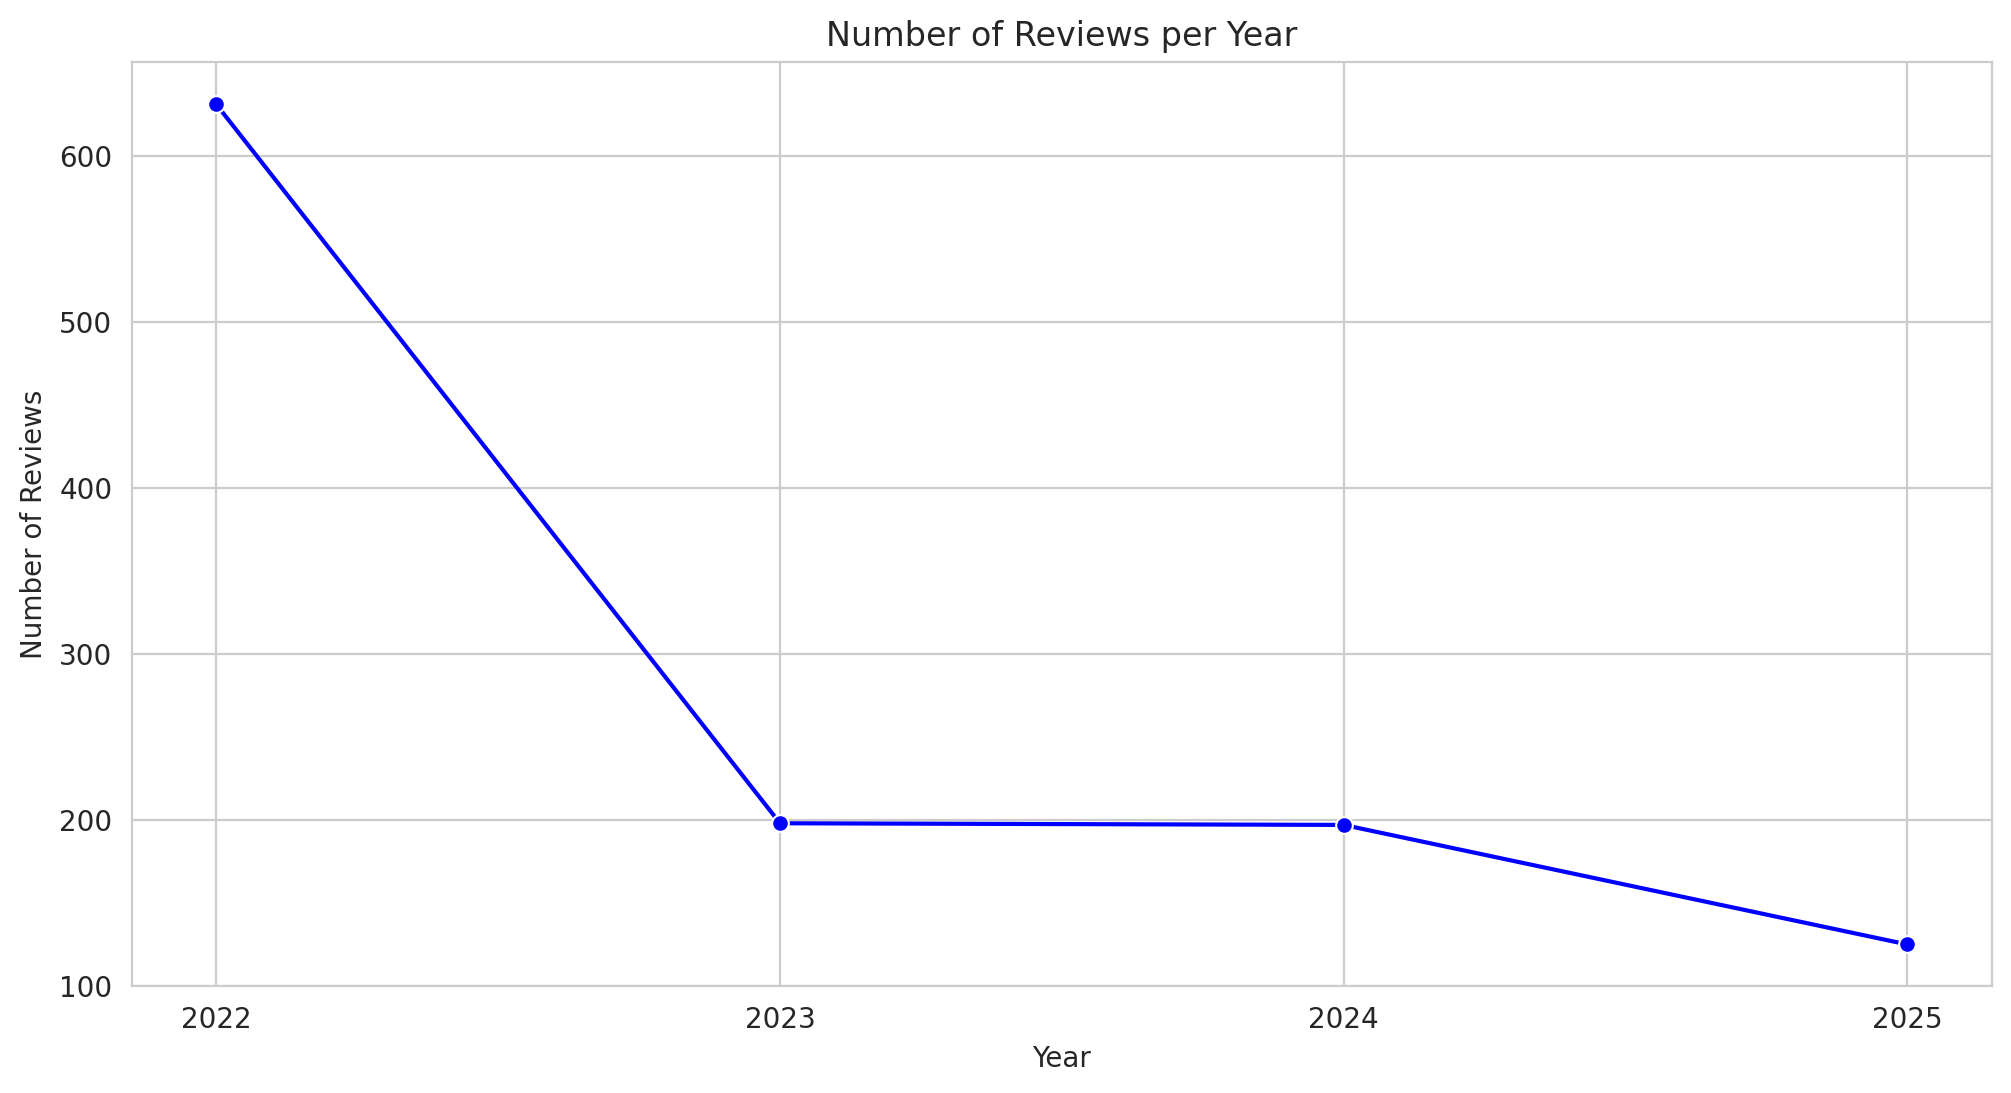

In [41]:
# Pastikan 'year' integer
df_jlingko['year'] = df_jlingko['at'].dt.year.astype(int)

# Hitung jumlah review per tahun
year_counts = df_jlingko['year'].value_counts().sort_index()

# Convert index jadi int juga
year_counts.index = year_counts.index.astype(int)

#plot
plt.figure(figsize=(12, 6))
sns.lineplot(x=year_counts.index, y=year_counts.values, marker='o', color='blue')
plt.title('Number of Reviews per Year')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.grid(True)

# Paksa sumbu X integer (tahun)
plt.xticks(year_counts.index)
plt.show()


### Review Score per Year

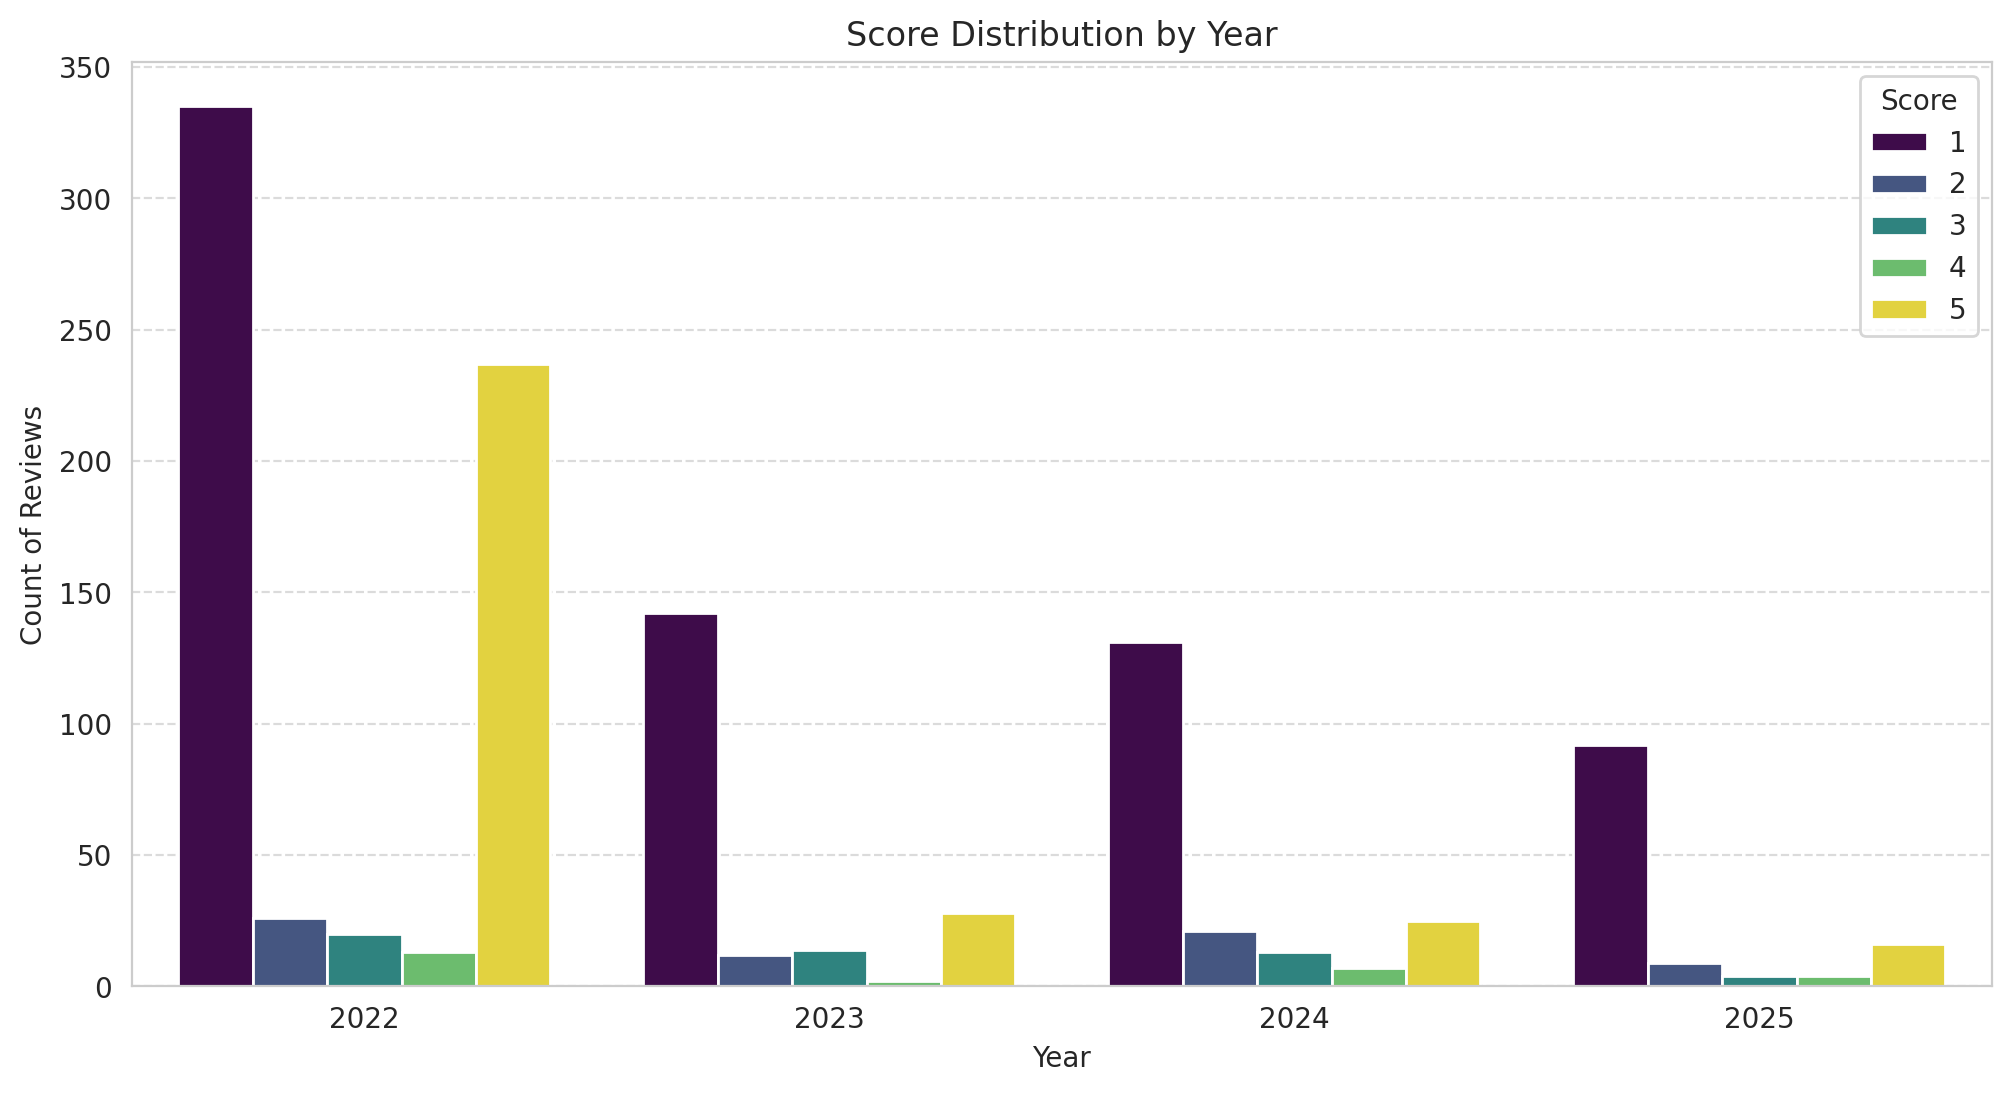

In [43]:
#Perbandingan skor review setiap tahun
plt.figure(figsize=(12, 6))
sns.countplot(x='year', hue='score', data=df_jlingko, palette='viridis')

plt.title('Score Distribution by Year')
plt.xlabel('Year')
plt.ylabel('Count of Reviews')
plt.legend(title='Score')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

### Review Sentiment Word Cloud

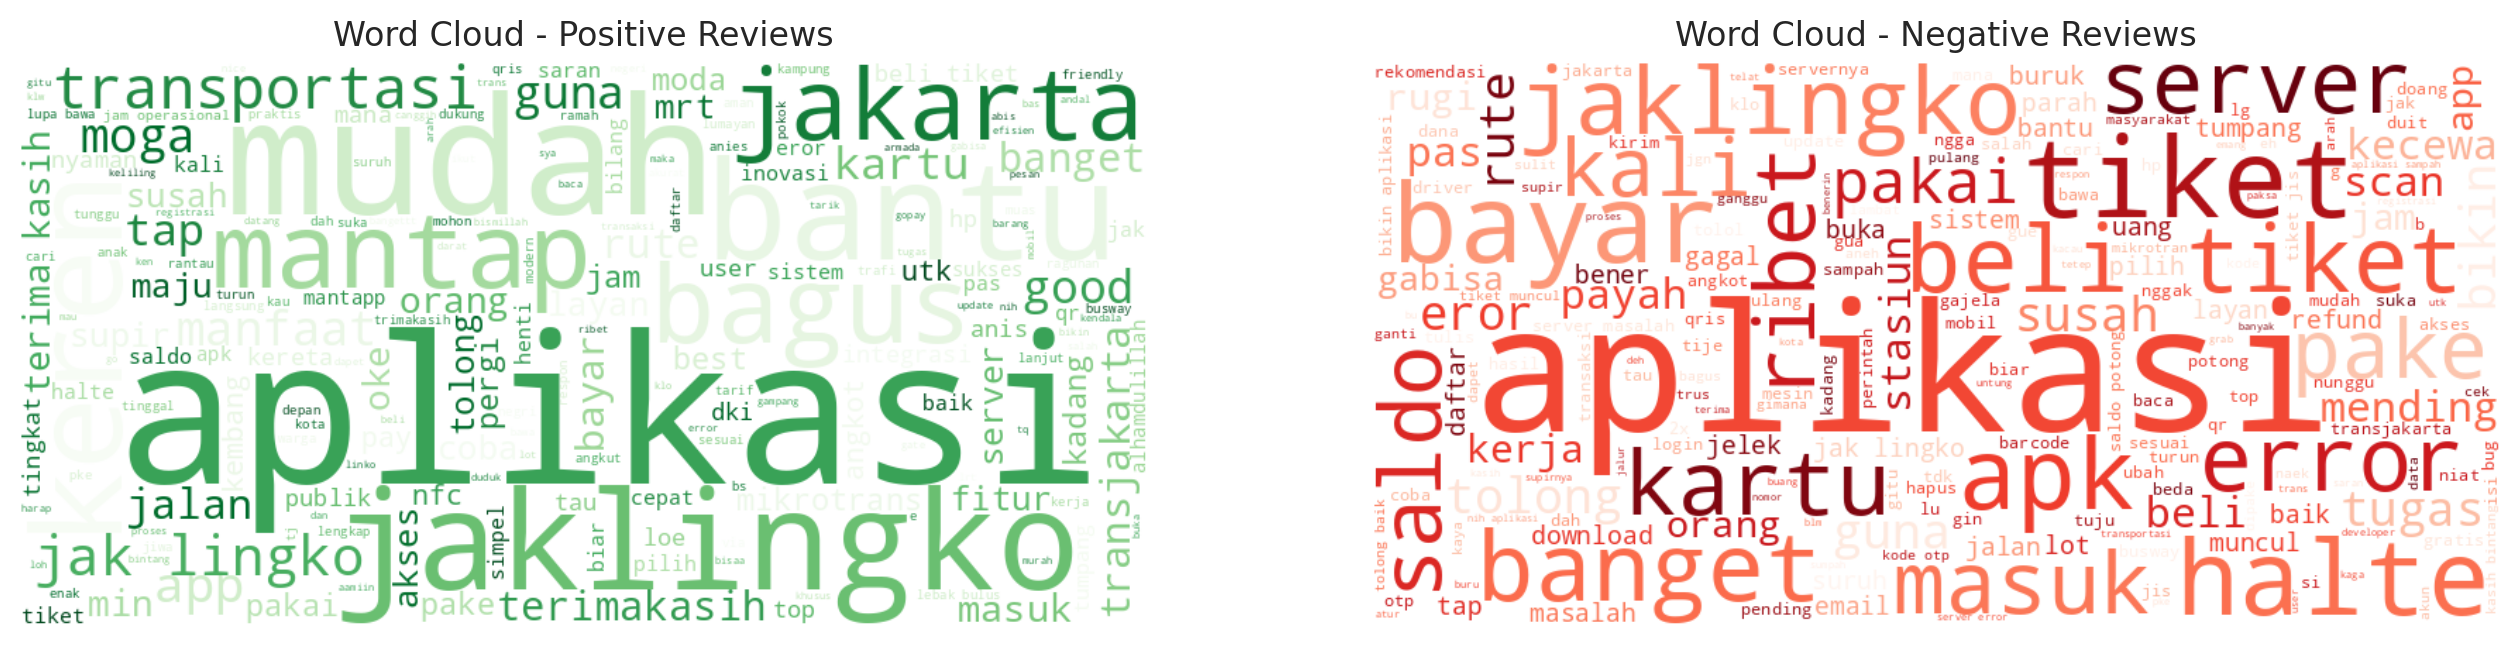

In [46]:
from wordcloud import WordCloud

# Pisahkan review positif dan negatif
positive_text = " ".join(df_jlingko[df_jlingko['sentiment_rating'] == 'Positive']['final_text'])
negative_text = " ".join(df_jlingko[df_jlingko['sentiment_rating'] == 'Negative']['final_text'])

# Generate word cloud positif
wordcloud_pos = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(positive_text)

# Generate word cloud negatif
wordcloud_neg = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(negative_text)

# Plot keduanya
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Positive Reviews')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Negative Reviews')

plt.show()
